# R Aquilae: model 4
---

In [7]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from torch.optim       import Adam
from tqdm              import tqdm
from astropy           import units, constants

from pomme.plot        import plot_cube_2D, plot_spectrum
from pomme.object      import AstroObject

from pomme.model       import TensorModel
from pomme.lines       import Line
from pomme.loss        import Loss, diff_loss

In [8]:
# Load relevant SIMBAD data on the object (in this case: the distance)
obj = AstroObject('R Aql')

Using the parallax distance.


In [9]:
# Specify the folder containing the observations
datafolder = '/STER/frederikd/shared/R_Aql_obs/'
# Load the observations
obs   = torch.from_numpy(np.load(f'{datafolder}/obs_CO_J=2-1_res=100x100x29.npy'))
freqs = torch.from_numpy(np.load(f'{datafolder}/frq_CO_J=2-1_res=100x100x29.npy'))

In [14]:
# Load the base model
model = TensorModel.load(f'{datafolder}/tm_R_Aql_base_res=100.h5')
model.info()

In [16]:
# Define an analytic model for the radial velocity
def analytic_velo(r, r_in, v_in, v_inf, beta):
    return v_in + (v_inf - v_in) * (1.0 - r_in / r)**beta

# Define an analytic model for the temperature
def analytic_T(r, r_in, T_in, epsilon):
    return T_in * (r_in / r)**epsilon

In [17]:
# Set initial values for the free parameters
r_x, r_y, r_z = model.get_radial_direction(origin='centre')
r             = model.get_radius          (origin='centre')

# Evaluate velocity field for inital data
velocity_r = analytic_velo(
    r     = torch.from_numpy(r),
    r_in  = r.min(),
    v_in  = 1.0e+1,
    v_inf = 1.0e+4,
    beta  = 1.0
)

# Evaluate temperature field for inital data
temperature = analytic_T(
    r       = torch.from_numpy(r),
    r_in    = r.min(),
    T_in    = 5.0e+3,
    epsilon = 0.5
)

vmax = velocity_r.max()

# Define model parameters
model['log_CO'          ] = np.log(1.0e+10 * (r.min()/r)**2)
model['velocity_r'      ] = velocity_r/vmax
model['log_temperature' ] = np.log(temperature)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)

loss = Loss(['rep', 'nrm_rep', 'reg_rho', 'reg_v_r', 'reg_tmp'])

# Define which parameters are free and which are fixed
model.fix_all()
model.free('log_CO')
model.free('velocity_r')
model.free('log_temperature')

model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +1.384e+01     +1.510e+01     +2.303e+01
  velocity_r                 Free          True     +1.010e-03     +9.894e-01     +1.000e+00
  log_temperature            Free          True     +6.220e+00     +6.536e+00     +8.517e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [5.59518907e+14 5.59518907e+14 5.59518907e+14]
shape: (100, 100, 100)


In [19]:
# Specify the the line data
line = Line('CO', 1)

You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol


In [20]:
spatial_average = obs.sum(axis=(0,1))
line_centre     = freqs[np.where(spatial_average==spatial_average.max())[0][0]].item()
line_centre

230502373528.7

In [21]:
v_rad = (line_centre - line.frequency) / line.frequency * constants.c.si.value
v_rad

-46328.79352163112

In [22]:
velos = (1.0 - freqs / line.frequency) * constants.c.si.value
velos = velos + v_rad
velos = velos / 1.0e+3
velos

tensor([-1.6509e+01, -1.5239e+01, -1.3969e+01, -1.2699e+01, -1.1429e+01,
        -1.0159e+01, -8.8896e+00, -7.6196e+00, -6.3497e+00, -5.0797e+00,
        -3.8098e+00, -2.5399e+00, -1.2699e+00, -5.0932e-14,  1.2699e+00,
         2.5399e+00,  3.8098e+00,  5.0797e+00,  6.3497e+00,  7.6196e+00,
         8.8896e+00,  1.0159e+01,  1.1429e+01,  1.2699e+01,  1.3969e+01,
         1.5239e+01,  1.6509e+01,  1.7779e+01,  1.9049e+01])

In [23]:
# Extract beam from the observation
# beam = Beam(dat)

In [40]:
# Define the forward model
# This makes sinthetic observations of the model
def forward(model):

    d = torch.from_numpy(model.get_radial_direction(origin='centre')[2])

    img = line.LTE_image_along_last_axis(
        abundance    = torch.exp(model['log_CO'          ]),
        v_turbulence = torch.exp(model['log_v_turbulence']),
        temperature  = torch.exp(model['log_temperature' ]),
        velocity_los =    vmax * model['velocity_r'] * d - v_rad,
        frequencies  = freqs,
        dx           = model.dx(0),
        img_bdy      = torch.zeros_like(obs)
    )
    
    # Correct the obtained image for the distance (and convert to Jansky)
    img *= model.dx(0) * model.dx(1) / obj.distance.si.value**2 / 1.0e-26

    # Convolve with beam (i.e. convert to Jy/beam)
    # img = beam.torch_apply(img)

    return img

In [45]:
def fit(loss, model, obs, N_epochs=100, lr=1.0e-1, w_rep=1.0, w_nrm_rep=1.0, w_reg=1.0):

    params = [
        model['log_CO'],
        model['velocity_r'],
        model['log_temperature']
    ]

    optimizer = Adam(params, lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model)
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * torch.nn.functional.mse_loss(img, obs)

        # Compute the normalised (per pixel) reproduction loss
        nrm = 1.0 / obs.mean(dim=2)
        loss['nrm_rep'] = w_nrm_rep * torch.nn.functional.mse_loss(
            torch.einsum('ijf, ij -> ijf', img, nrm),
            torch.einsum('ijf, ij -> ijf', obs, nrm)
        )

        # Compute the regularisation loss
        loss['reg_rho'] = w_reg * diff_loss(model['log_CO'])
        loss['reg_v_r'] = w_reg * diff_loss(torch.log(torch.abs(model['velocity_r'])+1.0e+6))
        loss['reg_tmp'] = w_reg * diff_loss(model['log_temperature'])
    
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

    return img

In [46]:
img = forward(model)

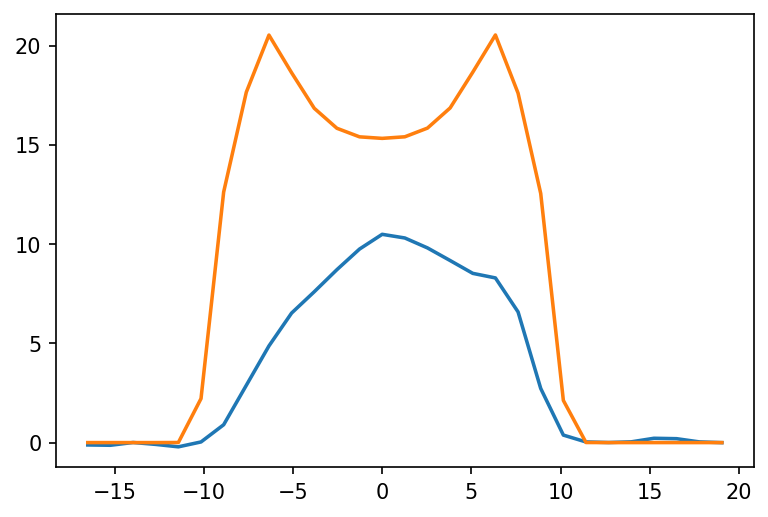

In [47]:
plt.figure(dpi=150)
plt.plot(velos, obs     .sum(axis=(0,1))/70000, linewidth=1.7)
plt.plot(velos, img.data.sum(axis=(0,1)),       linewidth=1.7)

In [48]:
img = fit(loss, model, obs/70000, N_epochs=5, lr=1.0e-1, w_rep=1.0e+0)
loss.renormalise_all()
loss.reset()

  0%|          | 0/5 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


100%|██████████| 3/3 [00:24<00:00,  8.25s/it]


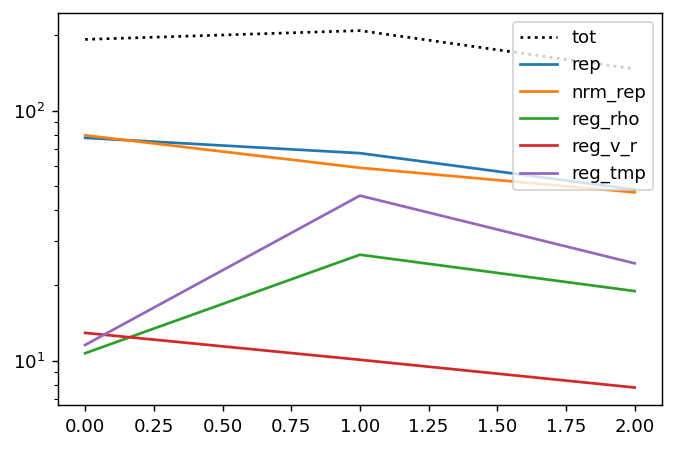

In [49]:
img = fit(loss, model, obs/70000, N_epochs=3, lr=1.0e-1, w_rep=1.0e+2, w_nrm_rep=1.0e+2, w_reg=1.0e+1)
loss.plot()

In [26]:
img = fit(loss, model, obs/70000, N_epochs=50, lr=1.0e-1, w_rep=1.0e+2, w_nrm_rep=1.0e+2, w_reg=1.0e+1)
loss.plot()

 46%|████▌     | 23/50 [03:00<03:26,  7.65s/it]

100%|██████████| 50/50 [07:12<00:00,  8.66s/it]


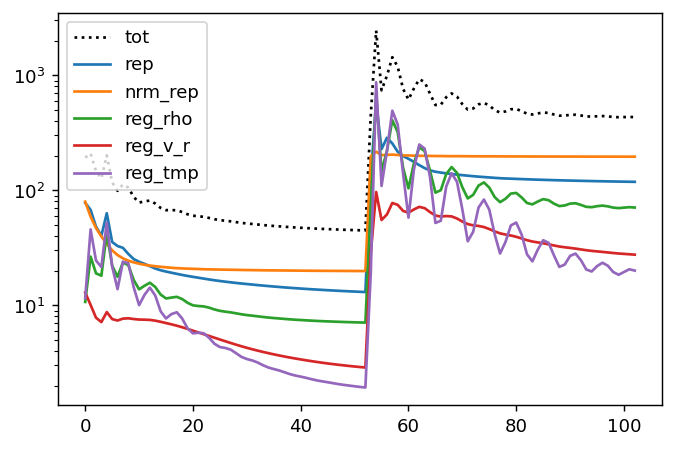

In [27]:
img = fit(loss, model, obs/70000, N_epochs=50, lr=1.0e-1, w_rep=1.0e+3, w_nrm_rep=1.0e+3, w_reg=1.0e+2)
loss.plot()

In [28]:
model.save('tm_R_Aql_model_4.h5')

In [ ]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
plot_cube_2D(model['velocity_r'])

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
plot_cube_2D(model['log_temperature'])

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +9.050e+00     +1.442e+01     +2.163e+01
  velocity_r                 Free          True     -4.851e-01     +1.040e+00     +4.004e+00
  log_T_in                   Free          False    +8.742e+00     +8.742e+00     +8.742e+00
  log_epsilon                Free          False    -1.142e+00     -1.142e+00     -1.142e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [5.59518907e+14 5.59518907e+14 5.59518907e+14]
shape: (100, 100, 100)
